<a href="https://colab.research.google.com/github/binhluong84/Machine-Learning/blob/main/Marvel_Character_Image_Classification_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Connect Google Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
image_dir = Path('/gdrive/MyDrive/Marvel Character Image Classification (Mobilenet)/archive/marvel')

In [4]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df['Label'].value_counts()

doctor strange     821
spider-man         766
captain america    762
thanos             756
hulk               754
black widow        750
ironman            748
loki               722
Name: Label, dtype: int64

In [5]:
samples = []
for category in image_df['Label'].unique():
    category_slice = image_df.query("Label == @category")
    samples.append(category_slice.sample(200, random_state=1))
image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

image_df['Label'].value_counts()

black widow        200
hulk               200
thanos             200
ironman            200
captain america    200
doctor strange     200
spider-man         200
loki               200
Name: Label, dtype: int64

In [6]:
image_df

,Filepath,Label
0,/gdrive/MyDrive/Marvel Character Image Classif...,black widow
1,/gdrive/MyDrive/Marvel Character Image Classif...,hulk
2,/gdrive/MyDrive/Marvel Character Image Classif...,thanos
3,/gdrive/MyDrive/Marvel Character Image Classif...,hulk
4,/gdrive/MyDrive/Marvel Character Image Classif...,ironman
...,...,...
1595,/gdrive/MyDrive/Marvel Character Image Classif...,loki
1596,/gdrive/MyDrive/Marvel Character Image Classif...,spider-man
1597,/gdrive/MyDrive/Marvel Character Image Classif...,captain america
1598,/gdrive/MyDrive/Marvel Character Image Classif...,doctor strange


In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 896 validated image filenames belonging to 8 classes.
Found 224 validated image filenames belonging to 8 classes.
Found 480 validated image filenames belonging to 8 classes.


In [10]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False 

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
28/28 [==============================] - 632s 22s/step - loss: 1.8680 - accuracy: 0.2913 - val_loss: 1.4732 - val_accuracy: 0.4866
Epoch 2/100
28/28 [==============================] - 17s 598ms/step - loss: 1.2101 - accuracy: 0.6038 - val_loss: 1.2593 - val_accuracy: 0.5759
Epoch 3/100
28/28 [==============================] - 17s 604ms/step - loss: 0.8819 - accuracy: 0.7143 - val_loss: 1.1937 - val_accuracy: 0.5938
Epoch 4/100
28/28 [==============================] - 17s 599ms/step - loss: 0.6216 - accuracy: 0.8125 - val_loss: 1.2037 - val_accuracy: 0.5625
Epoch 5/100
28/28 [==============================] - 17s 584ms/step - loss: 0.4366 - accuracy: 0.8761 - val_loss: 1.1606 - val_accuracy: 0.6161
Epoch 6/100
28/28 [==============================] - 17s 594ms/step - loss: 0.2732 - accuracy: 0.9364 - val_loss: 1.2621 - val_accuracy: 0.5938
Epoch 7/100
28/28 [==============================] - 16s 587ms/step - loss: 0.1607 - accuracy: 0.9754 - val_loss: 1.2300 - val_accuracy: 

15/15 [==============================] - 7s 399ms/step
Test Accuracy: 64.58%


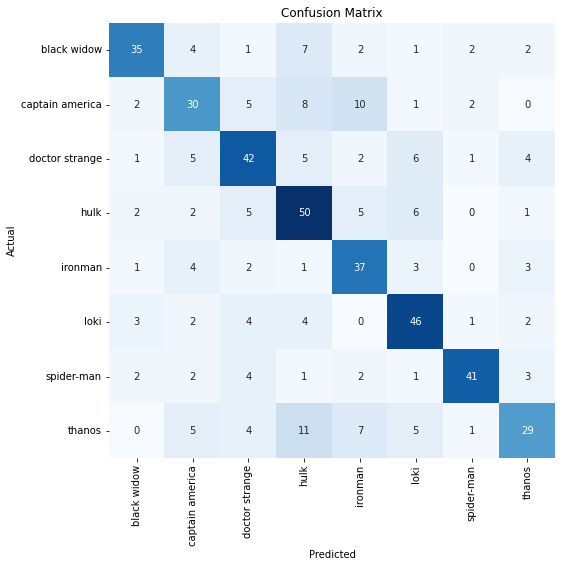

Classification Report:
----------------------
                  precision    recall  f1-score   support

    black widow       0.76      0.65      0.70        54
captain america       0.56      0.52      0.54        58
 doctor strange       0.63      0.64      0.63        66
           hulk       0.57      0.70      0.63        71
        ironman       0.57      0.73      0.64        51
           loki       0.67      0.74      0.70        62
     spider-man       0.85      0.73      0.79        56
         thanos       0.66      0.47      0.55        62

       accuracy                           0.65       480
      macro avg       0.66      0.65      0.65       480
   weighted avg       0.66      0.65      0.65       480



In [12]:
results = model.evaluate(test_images, verbose=0)
predictions = np.argmax(model.predict(test_images), axis=1)

class_names = list(test_images.class_indices.keys())

cm = confusion_matrix(test_images.labels, predictions, labels=np.arange(8))
clr = classification_report(test_images.labels, predictions, labels=np.arange(8), target_names=class_names)

print("Test Accuracy: {:.2f}%".format(results[1] * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(8) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(8) + 0.5, labels=class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)